# Pretrained Models

## Imports and Data

In [299]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import models, datasets, transforms
from torch import nn, optim
from sklearn.model_selection import train_test_split

In [259]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [225]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

In [301]:
dataset = datasets.ImageFolder(root='./dataset', transform=data_transform)

class_names = dataset.classes

train_size = 0.7
test_size = 0.15
val_size = 0.15



In [302]:
# Split indices into training and combined validation/test indices
train_indices, test_val_indices = train_test_split(range(len(dataset)), test_size=(val_size + test_size), random_state=42)

# Split combined validation/test indices into separate validation and test indices
val_indices, test_indices = train_test_split(test_val_indices, test_size=test_size/(val_size + test_size), random_state=42)

train_set = Subset(dataset, train_indices)  # Subset for training data
val_set = Subset(dataset, val_indices)      # Subset for validation data
test_set = Subset(dataset, test_indices)    # Subset for test data

In [303]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## GoogLeNet

### Model

In [304]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.is_available()

cpu


False

Loads Pretrained GoogLeNet Model with default training weights

In [305]:
default_weight_googlenet = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=default_weight_googlenet)

In [306]:
for param in googlenet_model.parameters():
    param.requires_grad = False

In [307]:
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_googlenet_model = googlenet_model

### Training


In [308]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_googlenet_model.parameters(), lr=0.001)

In [309]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [310]:
custom_callback = CustomCallback()

In [311]:
custom_callback.set_optimizer(optimizer)

In [312]:
tuned_googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [313]:
custom_callback.set_model(tuned_googlenet_model)

In [314]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [315]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_googlenet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_googlenet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_googlenet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_googlenet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Loss: 2.7660, Train Accuracy: 0.9882, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [2/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [3/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [4/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [5/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Early stopping triggered!


In [316]:
tuned_googlenet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_googlenet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 2.7309, Test Accuracy: 1.0000


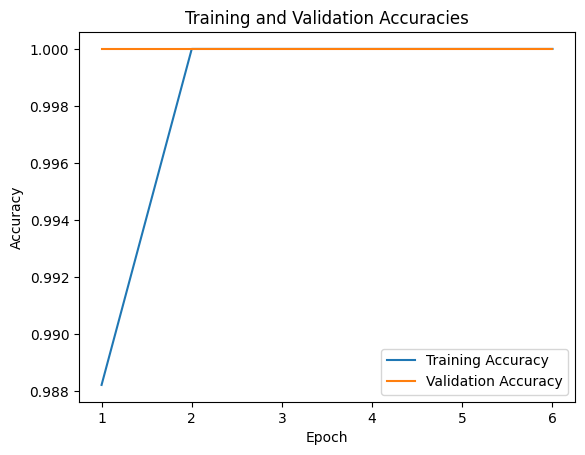

In [317]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

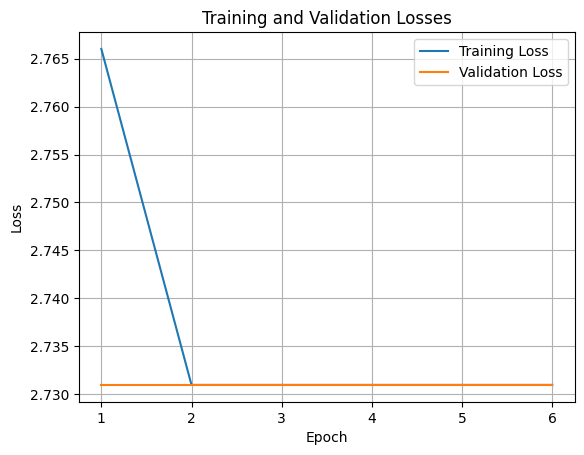

In [318]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

## MobileNet V3

### Model Small

In [319]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [320]:
default_weight_mobilenet = models.MobileNet_V3_Small_Weights.DEFAULT
mobilenet_model = models.mobilenet_v3_small(weights=default_weight_mobilenet)

In [321]:
# Freeze all layers
for param in mobilenet_model.parameters():
    param.requires_grad = False

In [322]:
num_features = mobilenet_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
mobilenet_model.classifier = new_head

tuned_mobilenet_model = mobilenet_model

#### Training

In [327]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_mobilenet_model.parameters(), lr=0.001)

In [328]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=3, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [329]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_mobilenet_model.to(device)
custom_callback.set_model(tuned_mobilenet_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [330]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_mobilenet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_mobilenet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_mobilenet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_mobilenet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [2/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Epoch [3/20], Train Loss: 2.7309, Train Accuracy: 1.0000, Val Loss: 2.7309, Val Accuracy: 1.0000
Early stopping triggered!


In [331]:
tuned_mobilenet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_mobilenet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 2.7309, Test Accuracy: 1.0000


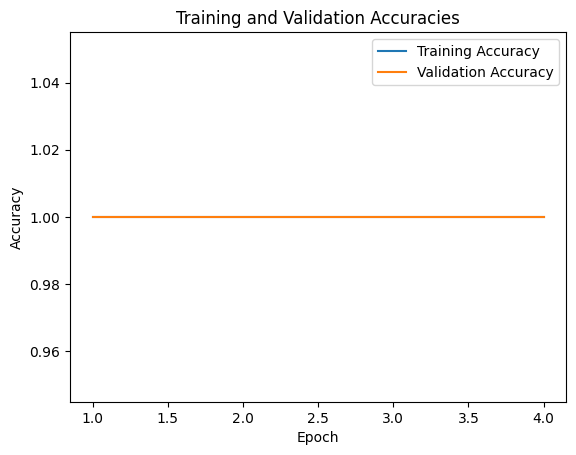

In [334]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

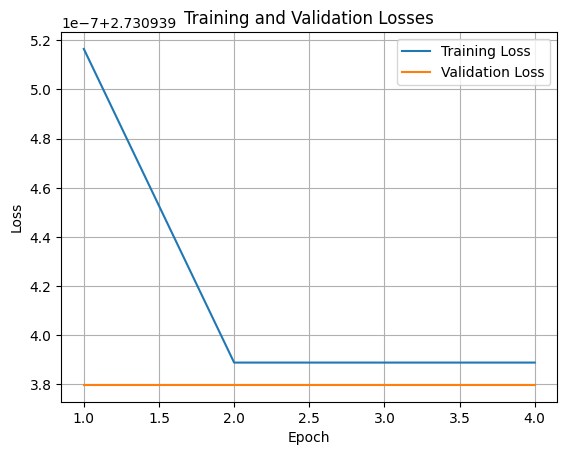

In [335]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

### Model Large

In [336]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [337]:
default_weight_mobilenet_Large = models.MobileNet_V3_Large_Weights.DEFAULT
mobilenet_large_model = models.mobilenet_v3_large(weights=default_weight_mobilenet_Large)

In [338]:
# Freeze all layers
for param in mobilenet_large_model.parameters():
    param.requires_grad = False

In [339]:
num_features = mobilenet_large_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
mobilenet_large_model.classifier = new_head

tuned_mobilenet_large_model = mobilenet_large_model

### Training


In [340]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_mobilenet_large_model.parameters(), lr=0.001)

In [341]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [342]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_mobilenet_large_model.to(device)
custom_callback.set_model(tuned_mobilenet_large_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [343]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_mobilenet_large_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_mobilenet_large_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_mobilenet_large_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_mobilenet_large_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 2.7893, Train Accuracy: 0.9878, Val Loss: 2.7318, Val Accuracy: 1.0000


In [ ]:
tuned_mobilenet_large_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_mobilenet_large_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 3.6140, Test Accuracy: 0.1087


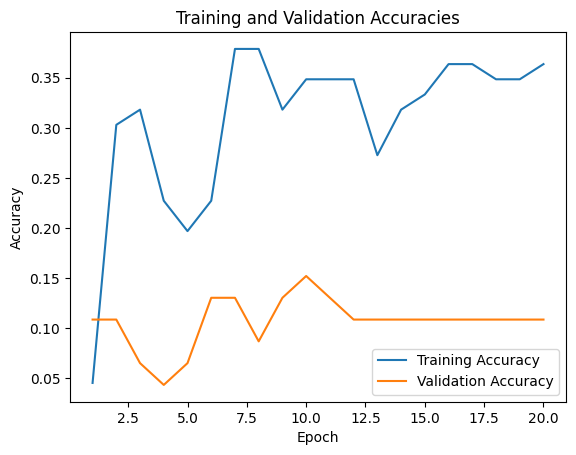

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

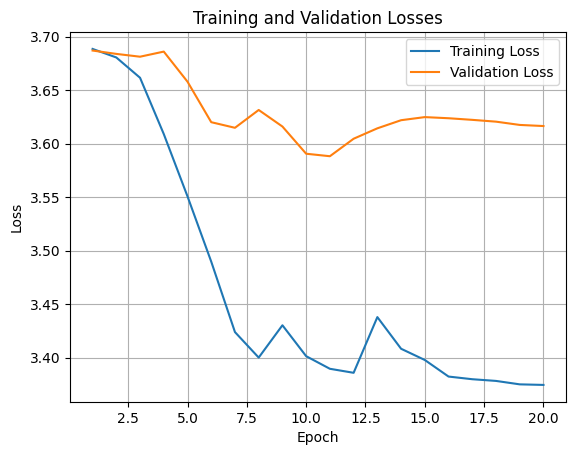

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

## AlexNet

### Model

In [ ]:
default_weight_AlexNet = models.AlexNet_Weights.DEFAULT
alexnet_model = models.alexnet(weights=default_weight_AlexNet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


In [ ]:
#freeze all layers
for param in alexnet_model.parameters():
    param.requires_grad = False

In [274]:
num_features = alexnet_model.classifier[6].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
alexnet_model.classifier[6] = new_head

tuned_alexnet_model = alexnet_model

AttributeError: 'Dropout' object has no attribute 'in_features'

In [ ]:
print(tuned_alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### training


In [239]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_mobilenet_model.parameters(), lr=0.001)

In [244]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=10, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [245]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_alexnet_model.to(device)
custom_callback.set_model(tuned_alexnet_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [246]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_alexnet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_alexnet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_alexnet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_alexnet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy
    
    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 3.6896, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [2/20], Train Loss: 3.6894, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [3/20], Train Loss: 3.6895, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [4/20], Train Loss: 3.6894, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [5/20], Train Loss: 3.6890, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [6/20], Train Loss: 3.6893, Train Accuracy: 0.0000, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [7/20], Train Loss: 3.6894, Train Accuracy: 0.0303, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [8/20], Train Loss: 3.6892, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [9/20], Train Loss: 3.6892, Train Accuracy: 0.0152, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [10/20], Train Loss: 3.6892, Train Accuracy: 0.0000, Val Loss: 3.6894, Val Accuracy: 0.0217
Epoch [11/20], Train Loss: 3.

In [247]:
tuned_alexnet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_alexnet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 3.6889, Test Accuracy: 0.0217


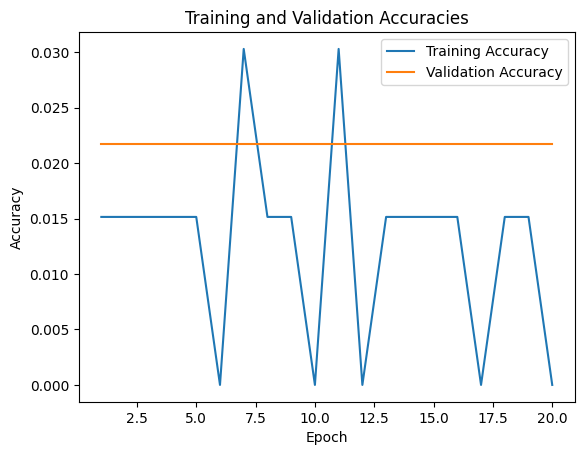

In [248]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

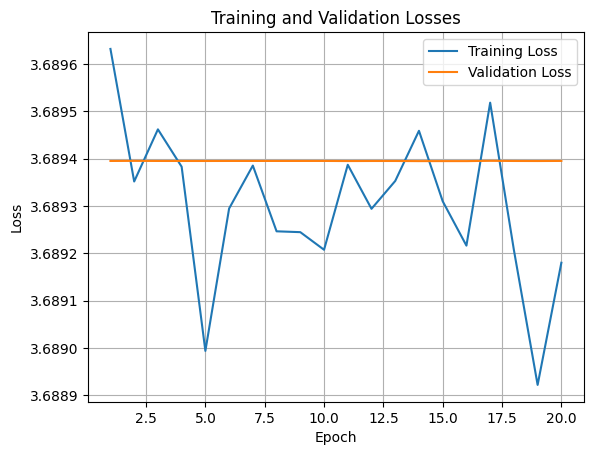

In [249]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

## ConvNeXt

### Model


#### Tiny

##### Load Model

In [271]:
default_weight_ConvNeXt_tiny = models.ConvNeXt_Tiny_Weights.DEFAULT
convnext_tiny_model = models.convnext_tiny(weights=default_weight_ConvNeXt_tiny)

In [272]:
#freeze all layers
for param in convnext_tiny_model.parameters():
    param.requires_grad = False

In [277]:
num_features = convnext_tiny_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
convnext_tiny_model.classifier[2] = new_head

tuned_convnext_tiny_model = convnext_tiny_model

In [284]:
print(tuned_convnext_tiny_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training 


In [285]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_convnext_tiny_model.parameters(), lr=0.001)

In [289]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=10, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [291]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_convnext_tiny_model.to(device)
custom_callback.set_model(tuned_convnext_tiny_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [295]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_convnext_tiny_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_convnext_tiny_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_convnext_tiny_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_convnext_tiny_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 3.6886, Train Accuracy: 0.0303, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [2/20], Train Loss: 3.6887, Train Accuracy: 0.0606, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [3/20], Train Loss: 3.6886, Train Accuracy: 0.0152, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [4/20], Train Loss: 3.6887, Train Accuracy: 0.0455, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [5/20], Train Loss: 3.6886, Train Accuracy: 0.0606, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [6/20], Train Loss: 3.6886, Train Accuracy: 0.0303, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [7/20], Train Loss: 3.6887, Train Accuracy: 0.0303, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [8/20], Train Loss: 3.6886, Train Accuracy: 0.0303, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [9/20], Train Loss: 3.6887, Train Accuracy: 0.0152, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [10/20], Train Loss: 3.6888, Train Accuracy: 0.0152, Val Loss: 3.6886, Val Accuracy: 0.0435
Epoch [11/20], Train Loss: 3.

In [296]:
tuned_convnext_tiny_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_convnext_tiny_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 3.6888, Test Accuracy: 0.0217


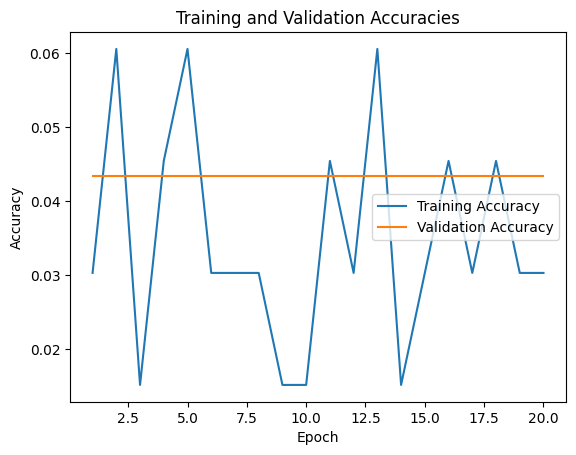

In [297]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

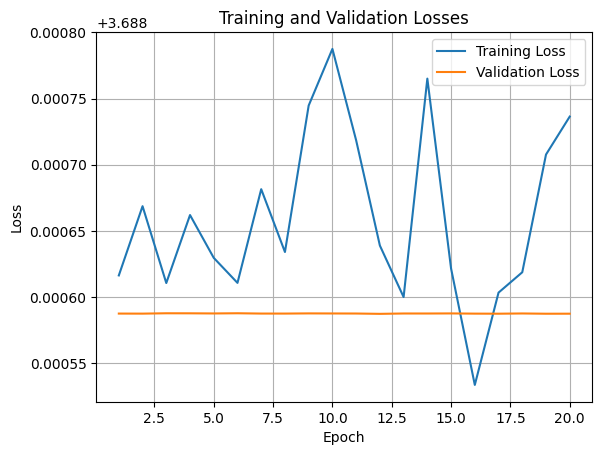

In [298]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

#### Small


##### Load Model


In [269]:
default_weight_ConvNeXt_small = models.ConvNeXt_Small_Weights.DEFAULT
convnext_small_model = models.convnext_small(weights=default_weight_ConvNeXt_small)

In [270]:
#freeze all layers
for param in convnext_small_model.parameters():
    param.requires_grad = False

In [278]:
num_features = convnext_small_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
convnext_small_model.classifier[2] = new_head

tuned_convnext_small_model = convnext_small_model

In [283]:
print(tuned_convnext_small_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training


In [286]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_convnext_small_model.parameters(), lr=0.001)

In [290]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=10, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [292]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_convnext_small_model.to(device)
custom_callback.set_model(tuned_convnext_small_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_convnext_small_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_convnext_small_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_convnext_small_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_convnext_small_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

In [ ]:
tuned_convnext_small_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_convnext_small_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

#### Base

##### Load Model

In [267]:
default_weight_ConvNeXt_base = models.ConvNeXt_Base_Weights.DEFAULT
convnext_base_model = models.convnext_base(weights=default_weight_ConvNeXt_base)

In [268]:
#freeze all layers
for param in convnext_base_model.parameters():
    param.requires_grad = False

In [279]:
num_features = convnext_base_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
convnext_base_model.classifier[2] = new_head

tuned_convnext_base_model = convnext_base_model

In [282]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

In [287]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_convnext_base_model.parameters(), lr=0.001)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=10, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [293]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_convnext_base_model.to(device)
custom_callback.set_model(tuned_convnext_base_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_convnext_base_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_convnext_base_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_convnext_base_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_convnext_base_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

In [ ]:
tuned_convnext_base_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_convnext_base_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

#### Large

##### Load Model

In [265]:
default_weight_ConvNeXt_large = models.ConvNeXt_Large_Weights.DEFAULT
convnext_large_model = models.convnext_large(weights=default_weight_ConvNeXt_large)

In [266]:
#freeze all layers
for param in convnext_large_model.parameters():
    param.requires_grad = False

In [280]:
num_features = convnext_large_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
convnext_large_model.classifier[2] = new_head

tuned_convnext_large_model = convnext_large_model

In [281]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

In [288]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_convnext_base_model.parameters(), lr=0.001)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=10, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [294]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
tuned_convnext_large_model.to(device)
custom_callback.set_model(tuned_convnext_large_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 20  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    tuned_convnext_large_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = tuned_convnext_large_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    tuned_convnext_large_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = tuned_convnext_large_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

In [ ]:
tuned_convnext_large_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = tuned_convnext_large_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

In [ ]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

## Densenet
